In [3]:
import numpy as np

In [4]:
def Pi(x: np.array):
    """
    Converts homogeneous to inhomogeneous coordinates
    Args:
        x (np.array) homogeneous coordinate

    Return:
        np.array converted inhomogeneous coordinate
    """

    return x[:-1] / x[-1]


def Piinv(x: np.array):
    """
    Converts inhomogeneous to homogeneous coordinates

    Args:
        x (np.array) inhomogeneous coordinate

    Return:
        np.array converted homogeneous coordinate
    """
    if x.ndim == 1:
        return np.concatenate((x, np.ones(1)))
    return np.vstack((x, np.ones((1, x.shape[1]))))

In [5]:
def skew(x: np.array):
    """
    This function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)
    https://stackoverflow.com/questions/36915774/form-numpy-array-from-possible-numpy-array

    Args:
        x (np.array): 1x3 matrix

    Return:
        s (np.array): 3x3 skew symmetrix matrix for cross product
    """
    vector = x.ravel()
    s = np.asarray(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[0]],
            [-vector[1], vector[0], 0],
        ]
    )
    return s

## Ex 4.1

In [6]:
R = np.asarray([[np.sqrt(0.5), -np.sqrt(0.5), 0], [np.sqrt(0.5), np.sqrt(0.5), 0], [0, 0, 1]])
t = np.asarray([0, 0, 10]).reshape(3, 1)
K = np.asarray([[1000, 0, 960], [0, 1000, 540], [0, 0, 1]])
P = K @ np.concatenate((R, t), axis=1)
P

array([[ 7.07106781e+02, -7.07106781e+02,  9.60000000e+02,
         9.60000000e+03],
       [ 7.07106781e+02,  7.07106781e+02,  5.40000000e+02,
         5.40000000e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         1.00000000e+01]])

In [7]:
from itertools import product

# Generate all combinations of (i, j, k)
world_points = np.asarray(list(product([0, 1], repeat=3)))

print("All 8 world_points:")
print(world_points)
world_points = Piinv(world_points.reshape(3, -1))
world_points

All 8 world_points:
[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]


array([[0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 1., 0., 0., 1.],
       [0., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.]])

In [8]:
image_points = P @ world_points
image_points.shape

(3, 8)

## Ex 4.2

In [9]:
def pest(Q: np.array, q: np.array):
    """
    Find projection matrix using DLT
    Args:
        Q (np.array): homogeneous real world points
        q (np.array): homogeneous image points

    Return:
        P (np.array): projection matrix from real to image
    """
    # Ensure Q and q are in homogeneous coordinates (3xN)
    A = []
    if Q.shape[0] == 2:
        Q = Piinv(Q)
    if q.shape[0] == 2:
        q = Piinv(q)
    num_points = Q.shape[1]
    for i in range(num_points):
        q_no_scale = q[:, i] / q[-1][i]
        q_skew = skew(q_no_scale.reshape(1, 3))
        B_i = np.kron(Q[:, i].T, q_skew)
        A.append(B_i)
    B = np.vstack(A)
    U, S, VT = np.linalg.svd(B)
    ## Important
    P = VT[-1, :].reshape(4, 3).T
    return P

In [10]:
calculated = pest(world_points, image_points)
scaled = calculated * np.linalg.norm(P) / np.linalg.norm(calculated)
scaled, P

(array([[ 7.07106781e+02, -7.07106781e+02,  9.60000000e+02,
          9.60000000e+03],
        [ 7.07106781e+02,  7.07106781e+02,  5.40000000e+02,
          5.40000000e+03],
        [ 2.40289311e-12,  4.23418666e-12,  1.00000000e+00,
          1.00000000e+01]]),
 array([[ 7.07106781e+02, -7.07106781e+02,  9.60000000e+02,
          9.60000000e+03],
        [ 7.07106781e+02,  7.07106781e+02,  5.40000000e+02,
          5.40000000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          1.00000000e+01]]))

In [11]:
np.linalg.norm(P - scaled) / world_points.shape[1]

6.931622180024931e-10

## Checkerboard calibration

In [12]:
def checkerboard_points(n: int, m: int):
    """
    Generate a checkerboard of points from dimensions n and m
    Args:
        n (int): number of rows
        m (int): number of cols

    Return:
        board (np.array): checkerboard points
    """
    A = []
    for i in range(n):
        for j in range(m):
            A.append([i - (n-1)//2, j - (m-1)//2, 0])
    board = np.vstack(A).T
    return board
checkerboard =  checkerboard_points(4, 4)
checkerboard.shape, checkerboard , checkerboard.T


((3, 16),
 array([[-1, -1, -1, -1,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2],
        [-1,  0,  1,  2, -1,  0,  1,  2, -1,  0,  1,  2, -1,  0,  1,  2],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 array([[-1, -1,  0],
        [-1,  0,  0],
        [-1,  1,  0],
        [-1,  2,  0],
        [ 0, -1,  0],
        [ 0,  0,  0],
        [ 0,  1,  0],
        [ 0,  2,  0],
        [ 1, -1,  0],
        [ 1,  0,  0],
        [ 1,  1,  0],
        [ 1,  2,  0],
        [ 2, -1,  0],
        [ 2,  0,  0],
        [ 2,  1,  0],
        [ 2,  2,  0]]))

## Ex 4.4

In [13]:
from scipy.spatial.transform import Rotation

In [14]:
n, m = 10, 20
checkerboard = checkerboard_points(n, m)

min_x = np.min(checkerboard[0, :])
max_x = np.max(checkerboard[0, :])
min_y = np.min(checkerboard[1, :])
max_y = np.max(checkerboard[1, :])

corners = np.array([
    [min_x, min_y, 0],  # Top-left
    [min_x, max_y, 0],  # Top-right
    [max_x, min_y, 0],  # Bottom-left
    [max_x, max_y, 0]   # Bottom-right
])
Q_corners = corners.T
Q_corners.shape, Q_corners

((3, 4),
 array([[-4, -4,  5,  5],
        [-9, 10, -9, 10],
        [ 0,  0,  0,  0]]))

In [15]:
Q_a = Rotation.from_euler('xyz', [np.pi/10, 0, 0]).as_matrix() @ Q_corners
Q_b = Rotation.from_euler("xyz", [0, 0, 0]).as_matrix() @ Q_corners
Q_c = Rotation.from_euler("xyz", [-np.pi / 10, 0, 0]).as_matrix() @ Q_corners
Q_a.shape, Q_b.shape, Q_c.shape

((3, 4), (3, 4), (3, 4))

In [16]:
qa = P @ Piinv(Q_a)
qb = P @ Piinv(Q_b)
qc = P @ Piinv(Q_c)
q_corners = P @ Piinv(Q_corners)

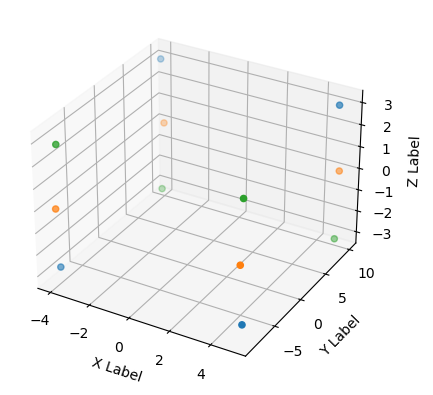

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(Q_a[0], Q_a[1], Q_a[2])
ax.scatter(Q_b[0], Q_b[1], Q_b[2])
ax.scatter(Q_c[0], Q_c[1], Q_c[2])

ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")

plt.show()

In [18]:
image_points = P @ Piinv(checkerboard)
image_points.shape

(3, 200)

## Ex 4.5

In [19]:
def hest(q1: np.array, q2: np.array):
    """
    Obtains estimated homography using linear algorithm

    Args:
        q1 (np.array): first set of points in 2D coordinates
        q2 (np.array): second set of points in 2D coordinates

    Return:
        H (np.array): Estimated homography matrix
    """
    A = []
    # Ensure q1 and q2 are in homogeneous coordinates (3xN)
    if q1.shape[0] == 2:
        q1 = Piinv(q1)
    if q2.shape[0] == 2:
        q2 = Piinv(q2)
    num_points = q1.shape[1]
    for i in range(num_points):
        # x1, y1, w = q1[:, i].T
        # x2, y2, wp = q2[:, i].T
        # B_check = np.asarray([[0, -x2, x2*y1, 0, -y2, y2*y1, 0, -1, y1],
        #            [x2, 0, -x2*x1, y2, 0, -y2*x1, 1, 0, -x1],
        #            [-x2*y1, x2*x1, 0, -y2*y1, y2*x1, 0, -y1, x1, 0]])
        # x1, y1, w1 = q1[:, i]  # First set of points
        # x2, y2, w2 = q2[:, i]  # Second set of points

        # Construct two rows per correspondence
        # A.append([-x1, -y1, -w1,  0,  0,  0, x2*x1, x2*y1, x2*w1])
        # A.append([0,  0,  0, -x1, -y1, -w1, y2*x1, y2*y1, y2*w1])
        q2_skew = skew(q2[:, i])
        B_i = np.kron(
            q1[:, i].reshape(1, 3),
            q2_skew,
        )
        # print((B_check == B_i).all())
        A.append(B_i)
    B = np.vstack(A)
    U, S, VT = np.linalg.svd(B)
    H = VT[-1, :].reshape(3, 3).T
    return H

In [20]:
# Q_a = Piinv(Q_a)
# print(Q_a[:-1], Q_a[-1])
# print("_____________")
# Q_test = np.vstack((Q_a[:-2], Q_a[-1]))
# Q_test

In [21]:
def estimateHomographies(Q_omega: np.array, qs: np.array):
    """
        Estimate a series of homographies between the setsof corresponding points
        Args:
            Q_omega (np.array): an array original un-transformed checkerboard points in 3D
            qs (np.array): a list of arrays, each element in the list containing 3D points projected to the image plane from different views

        Return:
            H_all (np.array): list of homography between lists of corresponding points
    """
    num_sets = Q_omega.shape[0]
    H_all = []
    for i in range(num_sets):
        set_Q = Q_omega[i, :]
        set_q = qs[i, :]
        if set_Q.shape[0] == 3:
            set_Q = Piinv(set_Q)
        if set_q.shape[0] == 2:
            set_q = Piinv(set_q)

        # Assume that the z=0 in the world for Q_omega
        # Remove z axis
        set_Q = np.vstack((set_Q[:-2], set_Q[-1]))
        assert set_q.shape == set_Q.shape
        H_all.append(hest(set_Q, set_q))
    return np.array(H_all)

In [22]:
Q_omega = np.stack([Q_a, Q_b, Q_c], axis=0)
qs = np.stack([qa, qb, qc], axis=0)
qs.shape, Q_omega.shape, qs
H_all = estimateHomographies(Q_omega, qs)

In [23]:
Q_test = Piinv(Q_b)
Q_b_no_z = np.vstack((Q_test[:-2], Q_test[-1]))
H = hest(Q_b_no_z, qb)
Pi(H_all[-1] @ Q_b_no_z), Pi(qb)

(array([[1233.55757178, -506.41738492, 1725.96120099,  436.27950539],
        [-171.24968663, 1168.46459354,  321.15394258, 2111.16148384]]),
 array([[1313.55339059,  -29.94949366, 1949.94949366,  606.44660941],
        [-379.23881554,  964.26406871,  257.15728753, 1600.66017178]]))

In [24]:
H_all.shape

(3, 3, 3)

## Ex 4.6

In [25]:
def generate_vi(homography, alpha, beta):
    """
    Generate the 1x6 vector vi^(alpha,beta) from homography elements.

    Args:
        homography (np.array): 3x3 homography matrix H_i
        alpha (int): col index for the first part (0, 1, or 2, corresponding to 1α, 2α, 3α)
        beta (int): col index for the second part (0, 1, or 2, corresponding to 1β, 2β, 3β)

    Returns:
        vi (np.array): 1x6 numpy array representing v_i^(alpha,beta)
    """
    col_alpha = homography[:, alpha]  
    col_beta = homography[:, beta]  

    # Compute the outer product of the two rows
    # This gives a 3x3 matrix, but we need to flatten it into 6 elements in the specific order
    outer_product = np.outer(col_alpha, col_beta)

    # [H_i^(1α)H_i^(1β), H_i^(1α)H_i^(2β) + H_i^(2α)H_i^(1β), H_i^(2α)H_i^(2β),
    #  H_i^(1α)H_i^(3β) + H_i^(3α)H_i^(1β), H_i^(2α)H_i^(3β) + H_i^(3α)H_i^(2β),
    #  H_i^(3α)H_i^(3β)]

    vi = np.array(
        [
            outer_product[0, 0],  # H_i^(1α)H_i^(1β)
            outer_product[0, 1]
            + outer_product[1, 0],  # H_i^(1α)H_i^(2β) + H_i^(2α)H_i^(1β)
            outer_product[1, 1],  # H_i^(2α)H_i^(2β)
            outer_product[0, 2]
            + outer_product[2, 0],  # H_i^(1α)H_i^(3β) + H_i^(3α)H_i^(1β)
            outer_product[1, 2]
            + outer_product[2, 1],  # H_i^(2α)H_i^(3β) + H_i^(3α)H_i^(2β)
            outer_product[2, 2],  # H_i^(3α)H_i^(3β)
        ]
    )

    return vi

In [26]:
def estimate_b(Hs: np.array):
    """
    Estimate b from a list of homographies
    Args:
        Hs (np.array): list of homographies

    Return:
        b (np.array): vector with variables from symmetric inv(K.T) @ inv(K)
    """
    V = []
    num_homographies = Hs.shape[0]
    for i in range(num_homographies):
        # Add constraints
        homography = Hs[i, :]
        V.append(generate_vi(homography, 0, 1))
        V.append(generate_vi(homography, 0, 0) - generate_vi(homography, 1, 1))
    V_stack = np.vstack(V)
    U, S, VT = np.linalg.svd(V_stack)
    b = VT[-1, :]
    return b

In [27]:
estimated_b = estimate_b(H_all)
B_true = np.linalg.inv(K).T @ np.linalg.inv(K)

b_true = np.asarray([B_true[0][0], B_true[0][1], B_true[1][1], B_true[0][2], B_true[1][2], B_true[2][2]]).T
h1 = H_all[0][:, 0]
assert generate_vi(H_all[0], 0, 0) @ b_true == h1.T @ B_true @ h1
estimated_b, b_true

(array([ 8.24266063e-07, -1.77569572e-19,  8.24266063e-07, -7.91295421e-04,
        -4.45103674e-04,  9.99999588e-01]),
 array([ 1.0000e-06,  0.0000e+00,  1.0000e-06, -9.6000e-04, -5.4000e-04,
         2.2132e+00]))

In [28]:
calculated_b_normalized = estimated_b / np.linalg.norm(estimated_b)
b_true_normalized = b_true / np.linalg.norm(b_true)
diff = calculated_b_normalized - b_true_normalized
relative_error = np.linalg.norm(diff) / np.linalg.norm(b_true_normalized)
relative_error

(0.00041021663896656464, (6,))

## Ex 4.7

In [57]:
import numpy as np

A = np.array([[4, 1], [1, 4]])
eigenvalues, U = np.linalg.eigh(A)  # eigh is for symmetric matrices
D = np.diag(eigenvalues)
A_reconstructed = U @ D @ U.T
A, A_reconstructed

(array([[4, 1],
        [1, 4]]),
 array([[4., 1.],
        [1., 4.]]))

In [61]:
import scipy

## Test reconstruction

In [64]:
estimated_b = estimate_b(H_all)
B11, B12, B22, B13, B23, B33 = (
    estimated_b[0],
    estimated_b[1],
    estimated_b[2],
    estimated_b[3],
    estimated_b[4],
    estimated_b[5],
)
B = np.asarray([[B11, B12, B13], [B12, B22, B23], [B13, B23, B33]])
B_inv = np.linalg.inv(B)
eigenvalues, U = np.linalg.eigh(B_inv)  # eigh is for symmetric matrices
D = np.diag(eigenvalues)
B_reconstructed = U @ D @ U.T
B_inv, B_reconstructed
D

array([[-1.13725289e+17,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.99963487e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.21319116e+06]])

In [70]:
import scipy.linalg


def estimateInstrinsics(Hs: np.array):
    """
    Estimate intrinsics from a list of homographies
    Args:
        Hs (np.array): list of homographies

    Return:
        K (np.array): Intrinsics matrix from homographies
    """
    estimated_b = estimate_b(Hs)
    B11, B12, B22, B13, B23, B33 = (
        estimated_b[0],
        estimated_b[1],
        estimated_b[2],
        estimated_b[3],
        estimated_b[4],
        estimated_b[5],
    )
    B = np.asarray([[B11, B12, B13], [B12, B22, B23], [B13, B23, B33]])

    # B^-1 can be represented as KK^T and also represented as UDU^T
    # K = UD^0.5
    # Compute B inverse
    B_inv = np.linalg.inv(B)
    # https://www.seas.ucla.edu/~vandenbe/133B/lectures/symm.pdf
    # Decompose B_inv to U D U^T since it is real and symmetric
    B_inv = np.linalg.inv(B)
    eigenvalues, U = np.linalg.eigh(B_inv)  # eigh is for symmetric matrices
    D = np.diag(eigenvalues)
    B_reconstructed = U @ D @ U.T
    K = np.dot(U, scipy.linalg.sqrtm(D))

    return K

In [71]:
K, estimateInstrinsics(H_all)

(array([[1000,    0,  960],
        [   0, 1000,  540],
        [   0,    0,    1]]),
 array([[-0.00000000e+00+2.93922868e+08j,  7.91284133e-04+0.00000000e+00j,
         -5.39998033e+02+0.00000000e+00j],
        [ 0.00000000e+00+1.65331613e+08j,  4.45089933e-04+0.00000000e+00j,
          9.59996503e+02+0.00000000e+00j],
        [-0.00000000e+00+3.06169655e+05j, -9.99981331e-01+0.00000000e+00j,
         -7.09573937e-06+0.00000000e+00j]]))